In [1]:
import pycmap 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import signal
from numpy_ext import rolling_apply


In [2]:
# set up API 
api = pycmap.API(token='68fbf4b0-22f4-11ec-a2c9-a3d02432460d')

In [3]:
# get all cruises in the seaflow table
def get_cruise_names():
    my_df = api.get_var_coverage('tblSeaFlow', 'cruise') # time and space bounds
    df_cruise_names= api.space_time(
        table='tblSeaFlow',
        variable='cruise',
        dt1=my_df['Time_Min'].iloc[0],
        dt2=my_df['Time_Max'].iloc[0],
        lat1=my_df['Lat_Min'].iloc[0],
        lat2=my_df['Lat_Max'].iloc[0],
        lon1=my_df['Lon_Min'].iloc[0],
        lon2=my_df['Lon_Max'].iloc[0],
        depth1=0,
        depth2=50
        )
    cruise_names = pd.unique(df_cruise_names['cruise'])
    return cruise_names

cruise_names = get_cruise_names()
print(cruise_names)

['TN248' 'Tokyo_3' 'CN11ID' 'TN271' 'TN280' 'CN12ID' 'TN292' 'KN210-04'
 'CN13ID' 'KM1427' 'KM1502' 'KM1508' 'KM1510' 'KM1512' 'KM1513' 'KOK1512'
 'KOK1515' 'KM1518' 'KM1601' 'KM1602' 'KM1603' 'KOK1604' 'KOK1606'
 'KOK1607' 'KOK1608' 'KOK1609' 'MGL1704' 'KM1708' 'KM1709' 'KM1712'
 'KM1713' 'KM1717' 'KM1802' 'FK180310-1' 'FK180310-2' 'KOK1801' 'KOK1803'
 'KOK1804' 'KOK1806' 'KOK1807' 'KM1821' 'KM1823' 'KM1901' 'KM1903'
 'KM1906' 'KM1909' 'KM1912' 'KM1915' 'KM1917' 'SR1917']


In [15]:
# turn lon,lat difference to distance in km 
# can take in a column of the df 
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    earth_radius = 6371 # km 
    return earth_radius * (
        np.arccos(np.sin(lat1) * np.sin(lat2) + \
                np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)))

In [23]:
# given a cruise name, return df of all samples joined with temp and PAR 
def get_cruise_data(cruise_name):
    # get slice of dataset that contains this cruise 
    df_cruise_bounds = api.cruise_bounds(cruise_name)
    dt1=df_cruise_bounds['dt1'].iloc[0]
    dt2=df_cruise_bounds['dt2'].iloc[0]
    lat1=df_cruise_bounds['lat1'].iloc[0] - 0.1
    lat2=df_cruise_bounds['lat2'].iloc[0] + 0.1
    lon1=df_cruise_bounds['lon1'].iloc[0] - 0.1
    lon2=df_cruise_bounds['lon2'].iloc[0] + 0.1
    # get prochloro data
    df_seaflow_prochloro_slice = api.space_time(
            table='tblSeaFlow',
            variable='abundance_prochloro',
            dt1=dt1,
            dt2=dt2,
            lat1=lat1,
            lat2=lat2,
            lon1=lon1,
            lon2=lon2,
            depth1=0,
            depth2=50
            )
    # get synecho data
    df_seaflow_synecho_slice = api.space_time(
        table='tblSeaFlow',
        variable='abundance_synecho',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    df_seaflow_cruise_slice = api.space_time(
        table='tblSeaFlow',
        variable='cruise',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # merge synecho column 
    df_seaflow_slice = pd.merge(df_seaflow_prochloro_slice, df_seaflow_synecho_slice)
    # merge cruise column 
    df_seaflow_slice = pd.merge(df_seaflow_slice, df_seaflow_cruise_slice)
    # get temp data
    df_temp_slice = api.space_time(
        table='tblCruise_Temperature',
        variable='temperature',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # get PAR data
    # PAR gathered from instrument on boat 
    df_par_slice = api.space_time(
        table='tblCruise_PAR',
        variable='par',
        dt1=dt1,
        dt2=dt2,
        lat1=lat1,
        lat2=lat2,
        lon1=lon1,
        lon2=lon2,
        depth1=0,
        depth2=50
        )
    # merge temp data
    df_master = pd.merge(df_seaflow_slice, df_temp_slice)
    # merge par data
    # TODO: sometimes this is empty, use other PAR source??? 
    df_master = pd.merge(df_master, df_par_slice)
    # calculate distance from previous point, must be sorted by time 
    df_master.sort_values(by='time')
    
    # TODO: change lat/lon to km 
    # the great circle distance 
    delta_d = great_circle(df_master['lon'], df_master['lat'],\
                           df_master['lon'].shift(), df_master['lat'].shift())
    df_master['d_distance_km'] = delta_d
    df_master['distance_km'] = delta_d.cumsum()
    
#     delta_d = np.sqrt((df_master['lat'] - df_master['lat'].shift())**2 
#                       + (df_master['lon'] - df_master['lon'].shift())**2)
#     df_master['distance'] = delta_d.cumsum() # in terms of lat/lon distance 
    return df_master
    
    
cruise_name = 'KOK1606'
df_master = get_cruise_data(cruise_name)
df_master

,time,lat,lon,depth,abundance_prochloro,abundance_synecho,cruise,temperature,par,d_distance_km,distance_km
0,2016-04-20T00:07:37,21.4614,-158.3132,5,169.538894,0.949190,KOK1606,25.8207,1939.90,NaN,NaN
1,2016-04-20T00:10:37,21.4688,-158.3151,5,168.822952,1.222280,KOK1606,25.8019,1939.90,0.846007,0.846007
2,2016-04-20T00:13:37,21.4760,-158.3171,5,166.512365,0.882712,KOK1606,25.8028,1939.90,0.826920,1.672927
3,2016-04-20T00:16:37,21.4833,-158.3193,5,169.099391,0.925650,KOK1606,25.7732,1766.60,0.843038,2.515965
4,2016-04-20T00:19:37,21.4906,-158.3214,5,173.349232,1.100617,KOK1606,25.7806,1766.60,0.840301,3.356266
...,...,...,...,...,...,...,...,...,...,...,...
6042,2016-05-04T02:15:43,22.9488,-157.9985,5,168.659414,2.271148,KOK1606,24.5007,900.66,0.811981,4581.825974
6043,2016-05-04T02:18:43,22.9415,-157.9985,5,171.156101,2.307625,KOK1606,24.5491,900.66,0.811723,4582.637697
6044,2016-05-04T02:21:44,22.9343,-157.9985,5,174.955139,2.659112,KOK1606,24.5144,869.88,0.800603,4583.438301
6045,2016-05-04T02:24:44,22.9272,-157.9987,5,166.077466,2.289011,KOK1606,24.4773,869.88,0.789750,4584.228050


,d_distance_km
count,6046.000000
mean,0.758357
std,4.391403
min,0.000000
25%,0.123527
50%,0.779451
75%,0.845081
max,184.007473


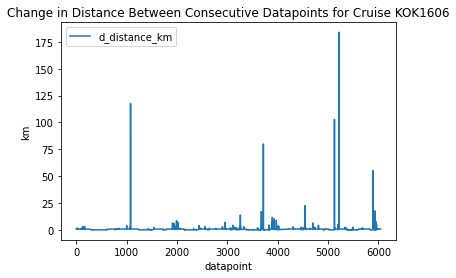

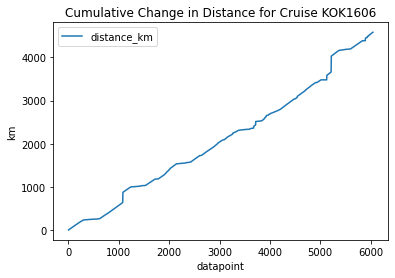

In [42]:
# plot change in distance between each point 
df_master.plot(y='d_distance_km', use_index=True)
plt.title(f"Change in Distance Between Consecutive Datapoints for Cruise {cruise_name}")
plt.xlabel('datapoint')
plt.ylabel('km')

df_master.plot(y='distance_km', use_index=True)
plt.title(f"Cumulative Change in Distance for Cruise {cruise_name}")
plt.xlabel('datapoint')
plt.ylabel('km')

df_master[['d_distance_km']].describe()

<AxesSubplot:xlabel='distance_km'>

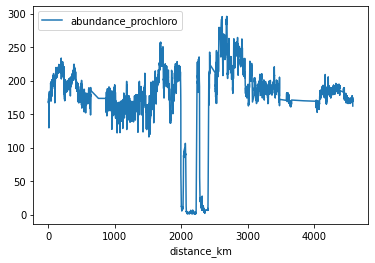

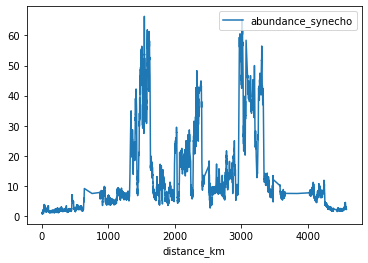

In [20]:
df_master.plot('distance_km','abundance_prochloro')
df_master.plot('distance_km', 'abundance_synecho')


In [21]:
# convolve with haar function 
ALPHA = 150

def haar_wavelet(points, alpha):
    result = []
    mid = points/2
    for i in range(points):
        if mid - alpha <= i < mid:
            result.append(-1/alpha)
        elif mid < i < mid + alpha:
            result.append(1/alpha)
        else:
            result.append(0)
    return result

def make_wavelet_plots(cruise_name):
    df_master = get_cruise_data(cruise_name)
    widths = [1, 50, 100, ALPHA]
    widths = [x+1 for x in range(ALPHA)]

    plt.title('Haar Wavelet Transform of Prochloroccus Abundance')
    plt.xlabel('distance (km)')
    plt.ylabel('alpha (km)')
    cwtmatr = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.show()

    plt.title('Haar Wavelet Transform of Synechococcus Abundance')
    plt.xlabel('distance (km)')
    plt.ylabel('alpha (km)')
    cwtmatr = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)
    plt.imshow(cwtmatr, cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.show()

    plt.title(f'Temperature for Cruise {cruise_name}')
    plt.xlabel('distance (km)')
    plt.ylabel('temperature (C)')
    plt.plot(df_master['distance_km'], df_master['temperature'])
    plt.show()

    plt.title(f'PAR for Cruise {cruise_name}')
    plt.xlabel('distance (km)')
    plt.ylabel('PAR (?)')
    plt.plot(df_master['distance_km'], df_master['par'])
    plt.show()


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


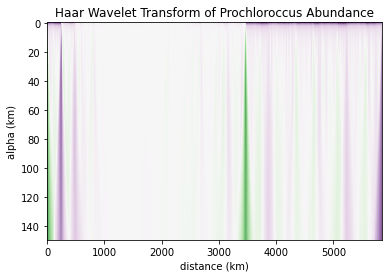

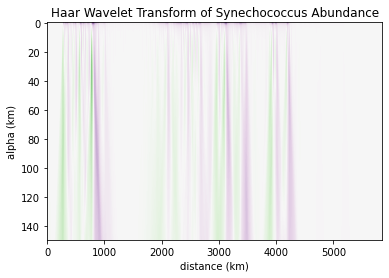

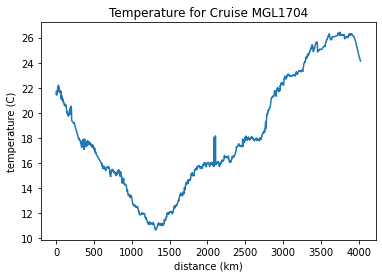

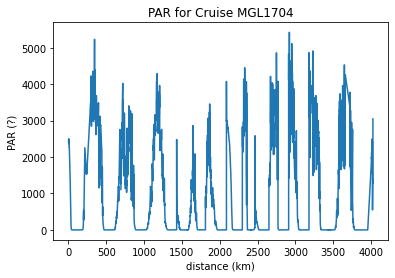

In [22]:
cruise_name = 'MGL1704'
make_wavelet_plots(cruise_name)

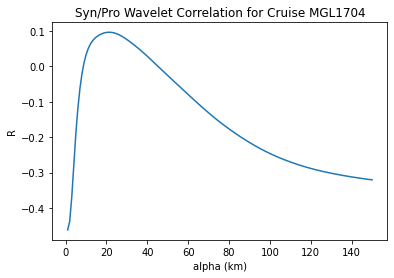

In [8]:
# plot R as a function of alpha between wavelets of pro and syn 
def plot_wavelet_corr_coefs(cruise_name, df_master = None, show_plot=True):
    if df_master is None:
        df_master = get_cruise_data(cruise_name)

    widths = [x+1 for x in range(ALPHA)]
    pro_wavelet = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    syn_wavelet = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)

    corrcoefs = []
    alpha = [] # width over which convolution was performed 
    for i in range(len(pro_wavelet)):
        alpha.append(i+1) #adding 1 because of zero indexing
        i_corrcoef_matrix = np.corrcoef(pro_wavelet[i], syn_wavelet[i])
        corrcoefs.append(i_corrcoef_matrix[0,1])
    if show_plot:
        plt.plot(alpha, corrcoefs)
        plt.title(f'Syn/Pro Wavelet Correlation for Cruise {cruise_name}')
        plt.xlabel('alpha (km)')
        plt.ylabel('R')
        plt.show()
    if not show_plot:
        return (alpha, corrcoefs)

plot_wavelet_corr_coefs(df_master['cruise'][0], df_master)

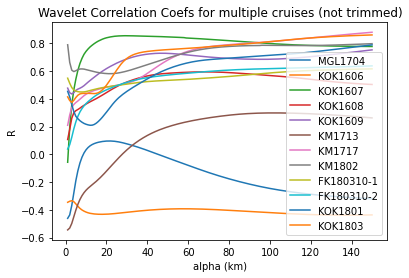

In [10]:
# Wavelet Correlation Coefs for multiple cruises (not trimmed)
cruise_names = get_cruise_names()[25:]
cruise_names = ['MGL1704', 'KOK1606', 'KOK1607', 'KOK1608', 'KOK1609','KM1713', 'KM1717', 'KM1802', 'FK180310-1', 'FK180310-2', \
                'KOK1801', 'KOK1803']

for cruise_name in cruise_names:
    alpha, corrcoefs = plot_wavelet_corr_coefs(cruise_name, show_plot=False)
    plt.plot(alpha, corrcoefs, label=cruise_name)
plt.legend()
plt.title('Wavelet Correlation Coefs for multiple cruises (not trimmed)')
plt.xlabel('alpha (km)')
plt.ylabel('R')
plt.show()

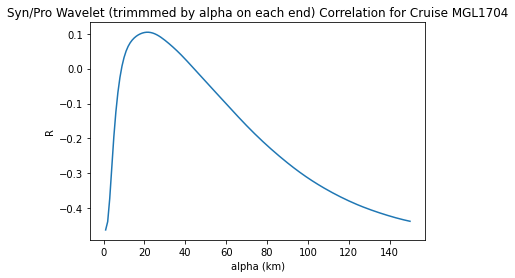

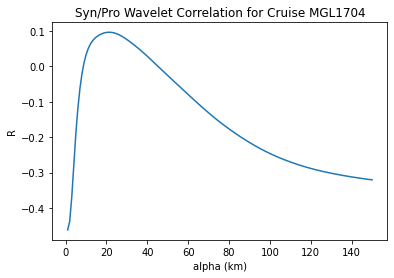

In [11]:
# trimmed the wavelet output by alpha on each end 
def plot_trimmed_wavelet_corr_coefs(cruise_name, df_master = None, show_plot=True):
    if df_master is None:
        df_master = get_cruise_data(cruise_name)

    widths = [x+1 for x in range(ALPHA)]
    pro_wavelet = signal.cwt(df_master['abundance_prochloro'], haar_wavelet, widths)
    syn_wavelet = signal.cwt(df_master['abundance_synecho'], haar_wavelet, widths)
    
    corrcoefs = []
    alphas = [] # width over which convolution was performed 
    for i in range(len(pro_wavelet)):
        alpha = i + 1 #adding 1 because of zero indexing
        alphas.append(alpha)
        # trim the wavelet by alpha on each end 
        pro_wavelet_trimmed = pro_wavelet[i][alpha:len(pro_wavelet[i]) - alpha]
        syn_wavelet_trimmed = syn_wavelet[i][alpha:len(syn_wavelet[i]) - alpha]
        i_corrcoef_matrix = np.corrcoef(pro_wavelet_trimmed, syn_wavelet_trimmed)
        corrcoefs.append(i_corrcoef_matrix[0,1])
    if show_plot:
        plt.plot(alphas, corrcoefs)
        plt.title(f'Syn/Pro Wavelet (trimmmed by alpha on each end) Correlation for Cruise {cruise_name}')
        plt.xlabel('alpha (km)')
        plt.ylabel('R')
        plt.show()
    if not show_plot:
        return (alphas, corrcoefs)

plot_trimmed_wavelet_corr_coefs(df_master['cruise'][0], df_master)
plot_wavelet_corr_coefs(df_master['cruise'][0], df_master)

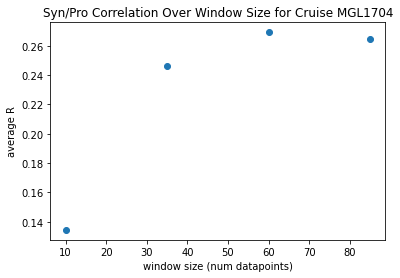

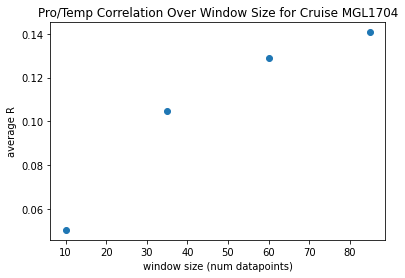

In [9]:
# Plot the avg correlation coefficient for a rolling window size

def get_corrcoef(col_1, col_2):
    corrcoef_matrix = np.corrcoef(col_1, col_2)
    return corrcoef_matrix[0,1]

def plot_rolling_window_corr_coefs(cruise_name, col_1, col_2, window_sizes=range(10,100,25), title="ADD TITLE"):
    avg_corrcoefs = []
    for window_size in window_sizes:
        # TODO: this can be parallelized 
        corrcoefs = rolling_apply(get_corrcoef, window_size, df_master[col_1], df_master[col_2], n_jobs=2)
        df_corrcoefs = pd.DataFrame({'corrcoefs': corrcoefs})
        avg_corrcoefs.append(df_corrcoefs.mean())
    
    plt.scatter(window_sizes, avg_corrcoefs)
    plt.title(title)
    plt.xlabel('window size (num datapoints)')
    plt.ylabel('average R')
    plt.show()
    plt.show()
    
pro = 'abundance_prochloro'
syn = 'abundance_synecho'
cruise_name = df_master['cruise'][0]
plot_rolling_window_corr_coefs(cruise_name, pro, syn, title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_rolling_window_corr_coefs(cruise_name, pro, 'temperature', title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')




In [258]:
# Plot the heatmap of correlation coefficients for a rolling window size 

from scipy.stats import gaussian_kde

# type: 'scatter' or 'hist2d'
def plot_corr_coefs_heatmap(cruise_name, col_1, col_2, window_sizes=range(1,5001,500), kind='scatter', title="ADD TITLE", ax=None, fig=None, df_master=None):
    if df_master is None:
        print(f"getting info for Cruise {cruise_name}...")
        df_master = get_cruise_data(cruise_name)
    
    if ax == None or fig == None:
        fig, ax = plt.subplots()
    avg_corrcoefs = []
    x = [] # window sizes
    y = [] # R vals
    for window_size in window_sizes:
        # TODO: this can be parallelized 
        corrcoefs = rolling_apply(get_corrcoef, window_size, df_master[col_1], df_master[col_2], n_jobs=2)
        # drop all NaNs from corrcoefs
        corrcoefs = corrcoefs[np.logical_not(np.isnan(corrcoefs))]
        x.append([window_size]*len(corrcoefs))
        y.append(corrcoefs.copy())

    # flatten the lists
    x = list(np.concatenate(x).flat)
    y = list(np.concatenate(y).flat)
    
    # convert from points to ~distance
    avg_d_distance = df_master['d_distance_km'].mean()
    x_km = [(i-1)*avg_d_distance for i in x]
    x = x_km
    
    # TODO: scale coloring based on # of points at each windowsize 
    if kind == 'scatter':
        # Calculate the point density
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        # Sort the points by density, so that the densest points are plotted last - BROKEN
        #     idx = z.argsort()
        #     x, y, z = x[idx], y[idx], z[idx]
        data = ax.scatter(x, y, c=z, cmap=plt.cm.jet)
        cbar = fig.colorbar(data, ax=ax)
    elif kind == 'hist2d':
        data = ax.hist2d(x, y, (len(window_sizes), 50), cmap=plt.cm.jet)
        cbar = fig.colorbar(data[3], ax=ax)
    
    cruise_name = df_master['cruise'][0]
    ax.set_title(title + " " + cruise_name)
    ax.set_xlabel('window size (km)')
    ax.set_ylabel('R')
    # change colorbar labels 
    cbar.set_ticks([])
    cbar.ax.set_ylabel('density of points', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
pro = 'abundance_prochloro'
syn = 'abundance_synecho'
cruise_name = df_master['cruise'][0]
print(cruise_name)
#plot_corr_coefs_heatmap(cruise_name, pro, syn, title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
#plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


KM1906


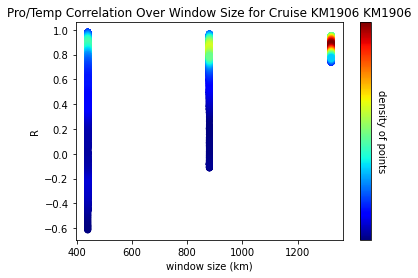

In [227]:
# test plot_corr_coefs_heatmap: scatter
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,2000,500), \
                        title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}', df_master=df_master)

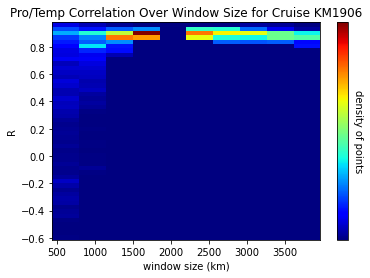

In [217]:
# test plot_corr_coefs_heatmap: hist2d
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,5001,500), kind='hist2d', \
                        title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')

x 250243
y 250243


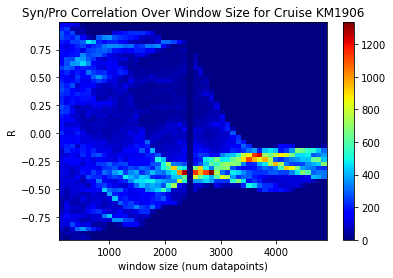

x 250243
y 250243


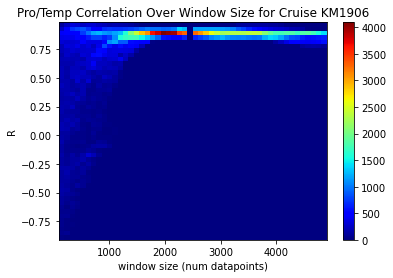

In [58]:
# RAN USING hist2d 
plot_corr_coefs_heatmap(cruise_name, pro, syn, window_sizes=range(1,5001,100), title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,5001,100),  title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


x 331551
y 331551


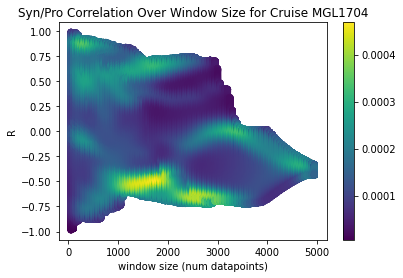

x 331551
y 331551


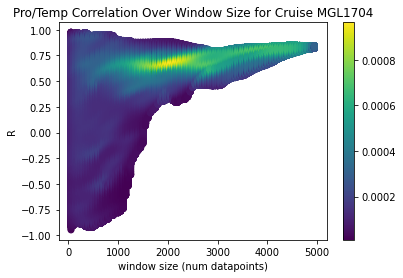

In [11]:
plot_corr_coefs_heatmap(cruise_name, pro, syn, window_sizes=range(1,5001,50), title=f'Syn/Pro Correlation Over Window Size for Cruise {cruise_name}')
plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=range(1,5001,50),  title=f'Pro/Temp Correlation Over Window Size for Cruise {cruise_name}')


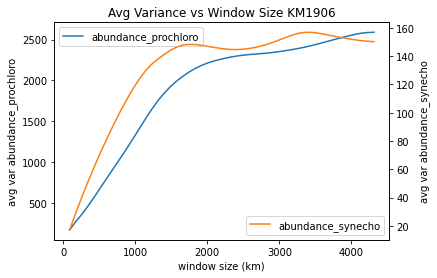

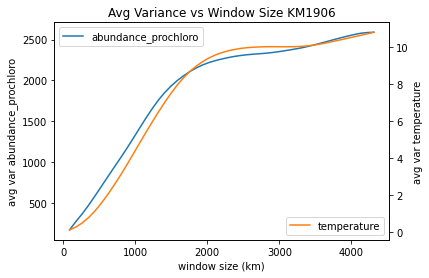

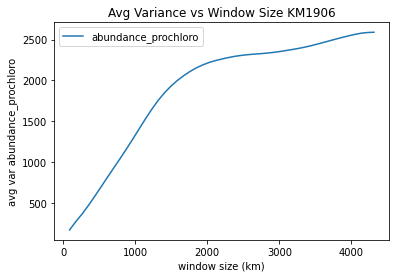

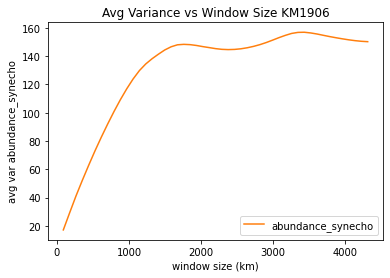

In [256]:
# PLOT VARIANCE 

def plot_variance_for_window_size(col_1, col_2 = None, window_sizes=range(1,5001,100), color=None, ax=None, df_master=df_master):
    if ax == None:
        fig, ax = plt.subplots()
    x = []
    y_1 = []
    y_2 = []
    for window_size in window_sizes:
        x.append(window_size)
        variances_1 = df_master[col_1].rolling(window_size).var()
        y_1.append(variances_1.mean())
        
        if col_2:
            variances_2 = df_master[col_2].rolling(window_size).var()
            y_2.append(variances_2.mean())
    
    # convert from points to ~distance
    avg_d_distance = df_master['d_distance_km'].mean()
    x_km = [(i-1)*avg_d_distance for i in x]
    x = x_km
    
    ax.plot(x, y_1, label=col_1, color=color)
    if col_2:
        ax_twin = ax.twinx()
        ax_twin.plot(x, y_2, label=col_2, color='tab:orange')
        ax_twin.set_ylabel(f'avg var {col_2}')
        ax_twin.legend(loc='lower right')
    cruise_name = df_master['cruise'][0]
    ax.set_title(f"Avg Var vs Window Size {cruise_name}")
    ax.set_xlabel('window size (km)')
    ax.set_ylabel(f'avg var {col_1}')
    ax.legend()
    
plot_variance_for_window_size(pro, syn)
plot_variance_for_window_size(pro, 'temperature')
plot_variance_for_window_size(pro)
plot_variance_for_window_size(syn, color='tab:orange')


In [44]:
# make list of "working" cruises (ones that don't throw an error )
cruises = get_cruise_names()
working_cruises = []
for cruise in cruises:
    try:
        print(f'trying to get {cruise}...')
        df_master = get_cruise_data(cruise)
    except Exception as e:
        print('blah :(')
        continue
    working_cruises.append(cruise)
    print("got it")
    
working_cruises

trying to get TN248...
blah :(
trying to get Tokyo_3...
blah :(
trying to get CN11ID...
blah :(
trying to get TN271...
got it
trying to get TN280...


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


got it
trying to get CN12ID...
blah :(
trying to get TN292...
blah :(
trying to get KN210-04...
got it
trying to get CN13ID...
blah :(
trying to get KM1427...
got it
trying to get KM1502...
got it
trying to get KM1508...
got it
trying to get KM1510...
got it
trying to get KM1512...
got it
trying to get KM1513...
got it
trying to get KOK1512...
got it
trying to get KOK1515...
got it
trying to get KM1518...
got it
trying to get KM1601...
got it
trying to get KM1602...
got it
trying to get KM1603...
got it
trying to get KOK1604...
got it
trying to get KOK1606...
got it
trying to get KOK1607...
got it
trying to get KOK1608...
got it
trying to get KOK1609...
got it
trying to get MGL1704...
got it
trying to get KM1708...
got it
trying to get KM1709...
got it
trying to get KM1712...
got it
trying to get KM1713...
got it
trying to get KM1717...
got it
trying to get KM1802...
got it
trying to get FK180310-1...
got it
trying to get FK180310-2...
got it
trying to get KOK1801...
got it
trying to g

['TN271',
 'TN280',
 'KN210-04',
 'KM1427',
 'KM1502',
 'KM1508',
 'KM1510',
 'KM1512',
 'KM1513',
 'KOK1512',
 'KOK1515',
 'KM1518',
 'KM1601',
 'KM1602',
 'KM1603',
 'KOK1604',
 'KOK1606',
 'KOK1607',
 'KOK1608',
 'KOK1609',
 'MGL1704',
 'KM1708',
 'KM1709',
 'KM1712',
 'KM1713',
 'KM1717',
 'KM1802',
 'FK180310-1',
 'FK180310-2',
 'KOK1801',
 'KOK1803',
 'KOK1804',
 'KOK1806',
 'KM1821',
 'KM1823',
 'KM1901',
 'KM1903',
 'KM1906']

df size: 1540
range(10, 1540, 308)


'TN280'

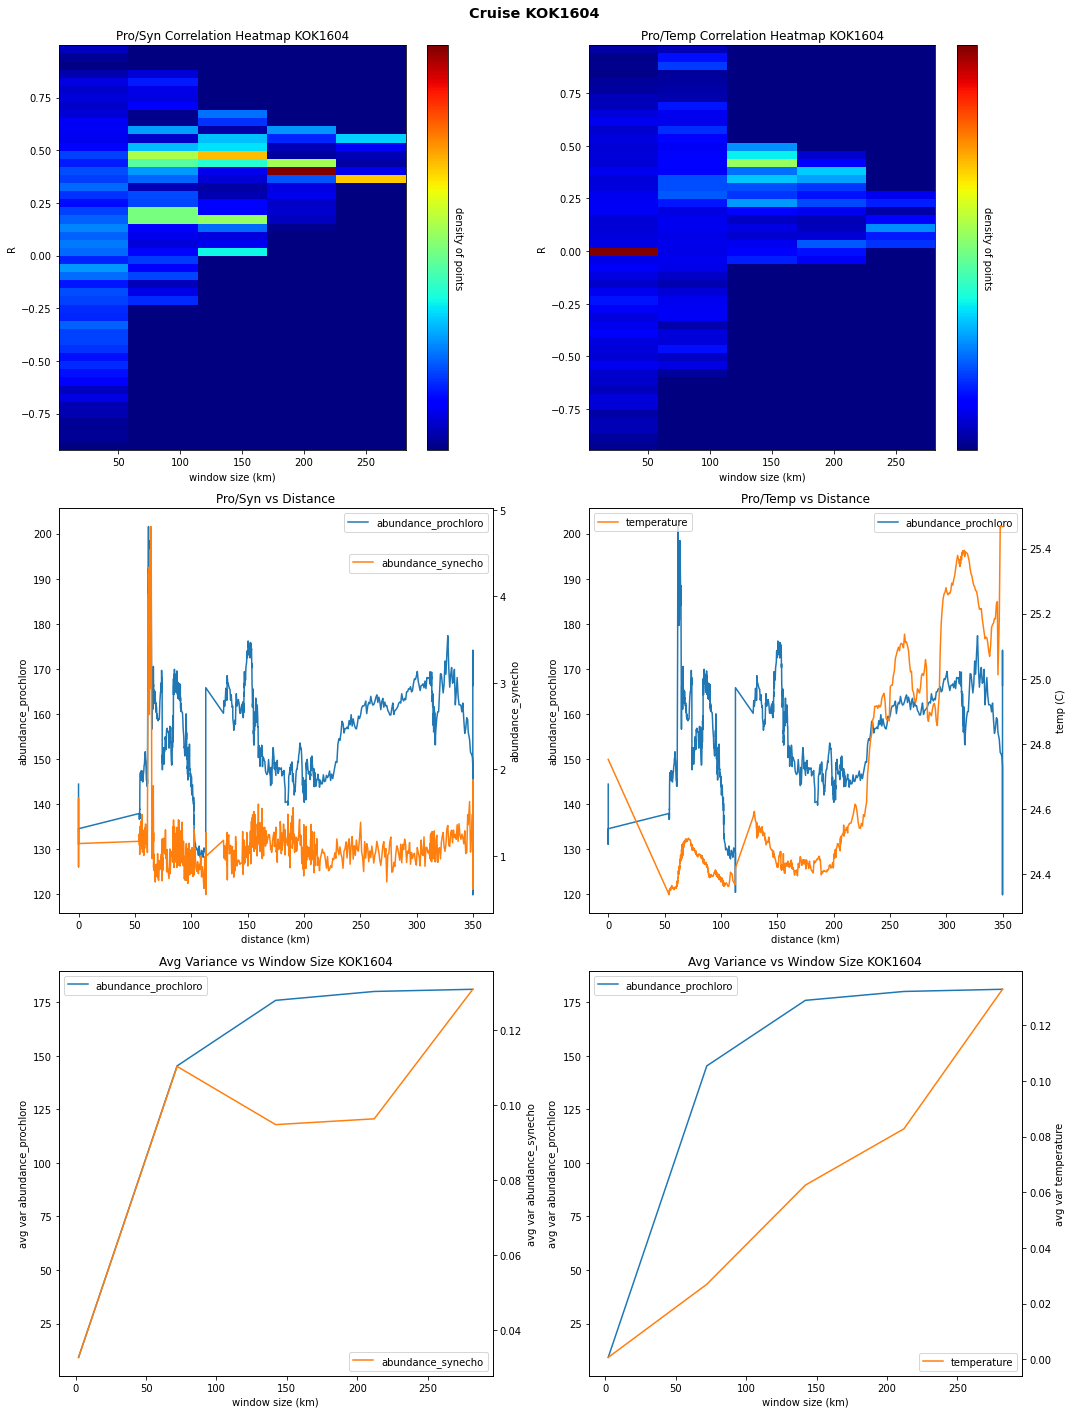

In [276]:
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")

# returns the fig for all 8 plots 
def figure_8(cruise_name):
    df_master = get_cruise_data(cruise_name)
    print('df size:', len(df_master))
    fig, axs = plt.subplots(3, 2)
    ax00 = axs[0,0] # pro/syn heatmap
    ax01 = axs[0,1] # pro/temp heatmap
    ax10 = axs[1,0] # pro/syn vs distance 
    ax11 = axs[1,1] # pro/temp vs distance
    ax20 = axs[2,0] # pro/syn variance
    ax21 = axs[2,1] # pro/temp variance 

    # TODO: do i have to pass in df_master? 
    # scale window sizes to df length 
    num_windows = 5
    window_sizes = range(10, len(df_master), int(len(df_master)/num_windows))
    print(window_sizes)
    
    # pro/syn heatmap
    plot_corr_coefs_heatmap(cruise_name, pro, syn, window_sizes=window_sizes, kind='hist2d', \
                            title=f'Pro/Syn Correlation Heatmap', ax=ax00, fig=fig, df_master=df_master)

    # pro/temp heatmap
    plot_corr_coefs_heatmap(cruise_name, pro, 'temperature', window_sizes=window_sizes, kind='hist2d', \
                            title=f'Pro/Temp Correlation Heatmap', ax=ax01, fig=fig, df_master=df_master)

    # pro/syn vs distance
    ax10.plot(df_master['distance_km'], df_master[pro], label=pro)
    ax10.set_ylabel(pro)
    ax10_twin = ax10.twinx()
    ax10_twin.plot(df_master['distance_km'], df_master[syn], label=syn, color="tab:orange")
    ax10_twin.set_ylabel(syn)
    ax10.set_title(f'Pro/Syn vs Distance')
    ax10.set_xlabel('distance (km)')
    ax10.legend()
    ax10_twin.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

    # pro/temp vs distance
    ax11.plot(df_master['distance_km'], df_master[pro], label=pro)
    ax11.set_ylabel(pro)
    ax11_twin = ax11.twinx()
    ax11_twin.plot(df_master['distance_km'], df_master['temperature'], label='temperature', color="tab:orange")
    ax11_twin.set_ylabel('temp (C)')
    ax11.set_title(f'Pro/Temp vs Distance')
    ax11.set_xlabel('distance (km)')
    ax11.legend()
    ax11_twin.legend(loc=2)


    # variance as a function of window
    plot_variance_for_window_size(pro, syn, ax=ax20, window_sizes=window_sizes, df_master=df_master)
    plot_variance_for_window_size(pro, 'temperature', ax=ax21, window_sizes=window_sizes, df_master=df_master)

    # Overall Formatting
    fig.suptitle(f'Cruise {cruise_name} \n', fontsize='x-large', fontweight='bold')
    fig.set_figwidth(15)
    fig.set_figheight(20)
    fig.tight_layout()
    
    return fig

figure_8('KOK1604')

cruise_name

In [ ]:
# Do it for each cruise 
# save all to one pdf 
import matplotlib.backends.backend_pdf
import datetime

pdf = matplotlib.backends.backend_pdf.PdfPages(f"output-{datetime.datetime.now()}.pdf")
for cruise_name in valid_cruises:
    my_fig = figure_8(cruise_name)
    pdf.savefig(my_fig)
pdf.close()
    

df size: 3139
range(10, 3139, 627)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 2049
range(10, 2049, 409)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 11891
range(10, 11891, 2378)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1405
range(10, 1405, 281)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 3545
range(10, 3545, 709)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1718
range(10, 1718, 343)
df size: 545
range(10, 545, 109)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1244
range(10, 1244, 248)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 4302
range(10, 4302, 860)
df size: 107
range(10, 107, 21)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1055
range(10, 1055, 211)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1388
range(10, 1388, 277)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1450
range(10, 1450, 290)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1493
range(10, 1493, 298)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 546
range(10, 546, 109)
df size: 1540
range(10, 1540, 308)
df size: 6047
range(10, 6047, 1209)
df size: 589
range(10, 589, 117)
df size: 1551
range(10, 1551, 310)
df size: 1655
range(10, 1655, 331)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


df size: 5849
range(10, 5849, 1169)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 1099
range(10, 1099, 219)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 5791
range(10, 5791, 1158)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 10441
range(10, 10441, 2088)


/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


df size: 7432
range(10, 7432, 1486)
df size: 947
range(10, 947, 189)
df size: 955
range(10, 955, 191)
df size: 4323
range(10, 4323, 864)


In [ ]:
# FINAL OUTPUT 

# list of cruise names that don't throw an error when trying to load data
valid_cruises = ['TN271',
 'TN280',
 'KN210-04',
 'KM1427',
 'KM1502',
 'KM1508',
 'KM1510',
 'KM1512',
 'KM1513',
 'KOK1512',
 'KOK1515',
 'KM1518',
 'KM1601',
 'KM1602',
 'KM1603',
 'KOK1604',
 'KOK1606',
 'KOK1607',
 'KOK1608',
 'KOK1609',
 'MGL1704',
 'KM1708',
 'KM1709',
 'KM1712',
 'KM1713',
 'KM1717',
 'KM1802',
 'FK180310-1',
 'FK180310-2',
 'KOK1801',
 'KOK1803',
 'KOK1804',
 'KOK1806',
 'KM1821',
 'KM1823',
 'KM1901',
 'KM1903',
 'KM1906']

for cruise_name in valid_cruises:
    # https://stackoverflow.com/questions/17788685/python-saving-multiple-figures-into-one-pdf-file
    # save a dict of all figures we output
    
    # pro/syn correlation coefficent heatmap plot 
    
    # pro/temp correlation coefficent heatmap plot 

    # get pro/syn vs distance 
    
    # get pro/temp vs distance
    
    # get varience (of pro? of syn? IDK ) vs distance 
    pass